# Sobel Operator #

The Sobel Operator is a discrete differentioation operator computing an approximation of the gradient of the image intensity funcion. At each point of the image, the result of the Sobel operator is based on convolving the image with a small, separable, and integer-valued filter in the horizontal and vertival directions and is therefore relativetely inexpensive in terms of computations.
On the other hand, the gradient approximation that it produces is relatively crude, in particular for high frequency variations in the image.


In [355]:
import torch
from skimage import io, transform
import matplotlib.pyplot as plt
import math
from skimage.transform import rescale, resize, downscale_local_mean
import time


## Kernels ##
two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. If we define A as the source image, and Gx and Gy are two images which at each point contain the horizontal and vertical derivative approximations respectively, the computations are as follows:

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/848abd56e0e33cf402f01183bfe1f68a93fb34a9 "im")

In [85]:
x=torch.tensor([[1.0,2.0,1.0],[0,0,0],[-1.0,-2.0,-1.0]], dtype=torch.float64)
y=x.t()
print('Gx =',x)
print('Gy =',y)

Gx = tensor([[ 1.,  2.,  1.],
        [ 0.,  0.,  0.],
        [-1., -2., -1.]], dtype=torch.float64)
Gy = tensor([[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]], dtype=torch.float64)


In [75]:

#mag = torch.zeros(5,4, dtype=torch.long)

for i in range(3):
    for j in range(3):
        S1=sum(sum(torch.mm(x,image[i:i+3,j:j+3])))
        S2=sum(sum(torch.mm(x,image[i:i+3,j:j+3])))
        mag[i+1,j+1]=math.sqrt(pow(2.0,S1)+pow(2.0,S2))


        

## Image Import ##

We import a black and white image

C:\Users\fcalcagno\AppData\Local\Continuum\Anaconda30\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


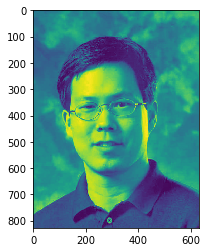

In [275]:
image = io.imread('faces/1198_0_861.jpg',as_grey=True)
image_rescaled = rescale(image, 1.0 / 1.0)
plt.imshow(image_rescaled)
plt.show()

Transformation of numpy vector to tensor

In [276]:
tensor_im= torch.from_numpy(image_rescaled)

In [277]:
rows=tensor_im.size()[0]
cols=tensor_im.size()[1]
print('rows: ', rows, '; cols:',cols)

rows:  828 ; cols: 630


## Convolution ##

In [365]:
start = time.time()
mag2=torch.zeros(tensor_im.size(),dtype=torch.double)
threshold=0.7
for i in range(rows-2):
    for j in range(cols-2):
        S1=sum(sum(torch.mm(x,tensor_im[i:i+3,j:j+3])))
        S2=sum(sum(torch.mm(y,tensor_im[i:i+3,j:j+3])))
        mag[i+1,j+1]=torch.sqrt(pow(2.0,S1)+pow(2.0,S2))
output_image= torch.where(mag>0.5,mag,mag2)
done = time.time()
elapsed = done - start
print(elapsed)

55.75471496582031


It took  55.8 seconds to make the convolution and the calculatin of the output.

## Output Image with borders ##

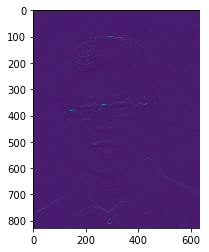

In [366]:
plt.imshow(output_image)
plt.show()

## 2D Convolution using Pytorch ##

In the following lines I try to implement the same code above using Pytorch library.

I'll use the models Variable and functional to create an ad-hoc  convolution with fixed weights.
I also create a tensor with both kernels to facilitate the convolution.

In [370]:
import torch.nn.functional as F
from torch.autograd import Variable
weights=torch.tensor([[[1.0,2.0,1.0],
                       [0.0,0.0,0.0],
                       [-1.0,-2.0,-1.0]],
                [[ 1.,  0., -1.],
        [ 2.,  0., -2.],
        [ 1.,  0., -1.]]] , dtype=torch.double)

The process executes the convolution (with a 1 pixel padding to fit the image) and then combines the feqtures vectors using the square root of the sum of the square of the feqture vectors position by position, to obtain a final image of the same size of the input

In [371]:
start = time.time()
convmag = F.conv2d(Variable(tensor_im.view(1,1,rows, cols)),Variable(weights.view(2,1,3,3)),padding=1)
final=torch.sqrt(torch.sum(torch.pow(2.0,convmag.view(1,2,rows, cols)), dim=1))
mag2=torch.zeros(tensor_im.size(),dtype=torch.double)
final2=torch.where(final>1.5,final,mag2)
mag=final2.squeeze()
done = time.time()
elapsed = done - start
print(elapsed)

0.09360170364379883


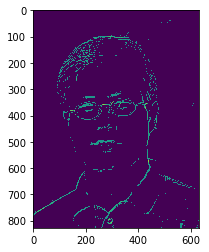

In [372]:
plt.imshow(mag)
plt.show()

The result is exactly the same and it's calculated 0,14 seconds, an impressive result.